In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

# face_recognition

In [23]:
import cv2
from IPython.display import display, Image

face_cascade = FD.initialize()
video = cv2.VideoCapture('http://192.168.2.36:4747/video')
video.set(3,480) # adjust width
video.set(4,480) # adjust height
video.set(cv2.CAP_PROP_BUFFERSIZE, 0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        result = FD.face_detect(frame, face_cascade)
        _, result = cv2.imencode('.jpeg', result)
        display_handle.update(Image(data=result.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

# insightface

In [24]:
import cv2
from IPython.display import display, Image

face_cascade = ID.initialize()
video = cv2.VideoCapture('http://192.168.2.36:4747/video')
video.set(3,480) # adjust width
video.set(4,480) # adjust height
video.set(cv2.CAP_PROP_BUFFERSIZE, 10)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        result = ID.person_detect(frame, face_cascade)
        _, result = cv2.imencode('.jpeg', result)
        display_handle.update(Image(data=result.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


None

# deepface

In [59]:
from deepface import DeepFace
from deepface.detectors import FaceDetector
from deepface.commons import functions


def detect_face(img, backend, align = True):

    #detector stored in a global variable in FaceDetector object.
    #this call should be completed very fast because it will return found in memory
    #it will not build face detector model in each call (consider for loops)
    face_detector = FaceDetector.build_model(backend)
    detected_face = None
    img_region = None
    try:
        detected_face, img_region = FaceDetector.detect_face(face_detector, backend, img, align)
    except:
        pass
    return detected_face, img_region

# def detect_face(detector, wrapper, img, align = True):

#     faces = wrapper(detector, img, align)
#     return faces

# def resize_image(img, target_size=(224,224), grayscale=False):
#     factor_0 = target_size[0] / img.shape[0]
#     factor_1 = target_size[1] / img.shape[1]
#     factor = min(factor_0, factor_1)

#     dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
#     img = cv2.resize(img, dsize)

#     # Then pad the other side to the target size by adding black pixels
#     diff_0 = target_size[0] - img.shape[0]
#     diff_1 = target_size[1] - img.shape[1]
#     if grayscale == False:
#         # Put the base image in the middle of the padded image
#         img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
#     else:
#         img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')
        
#     if img.shape[0:2] != target_size:
#         img = cv2.resize(img, target_size)
        
#     return img

# def normalize(image):
#     img_pixels = np.expand_dims(image, axis = 0)
#     img_pixels /= 255 #normalize input in [0, 1]
#     return img_pixels

# def preprocess_face(face_img, target_size=(224, 224)):
#     image = resize_image(face_img, target_size)
#     norm_image = normalize(image)
#     return norm_image



recognizer = DeepFace.build_model('ArcFace')
detector_backends = [
    'opencv', 
    'ssd', 
    'dlib', 
    'mtcnn', 
    'retinaface', 
    'mediapipe'
]
be = detector_backends[1]

In [88]:
%%time

for _ in range(10):
    recognizer = DeepFace.build_model('ArcFace')

CPU times: user 2.3 ms, sys: 342 µs, total: 2.65 ms
Wall time: 2.29 ms


In [90]:
%%timeit

recognizer = DeepFace.build_model('ArcFace')

844 ns ± 4.12 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [74]:
def preprocess_face_image(img, target_size = (224,224,), grayscale=False):
    factor_0 = target_size[0] / img.shape[0]
    factor_1 = target_size[1] / img.shape[1]
    factor = min(factor_0, factor_1)

    dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
    img = cv2.resize(img, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - img.shape[0]
    diff_1 = target_size[1] - img.shape[1]
    if grayscale == False:
        # Put the base image in the middle of the padded image
        img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
    else:
        img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    img_pixels = np.expand_dims(img, axis = 0).astype(np.float32)
    img_pixels /= 255 #normalize input in [0, 1]
    
    return img_pixels

In [80]:
import cv2
from IPython.display import display, Image, JSON

video = cv2.VideoCapture('http://192.168.2.36:4747/video')
video.set(3,640) # adjust width
video.set(4,640) # adjust height
video.set(cv2.CAP_PROP_BUFFERSIZE, 0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        face, location = detect_face(frame, be, align=False)
        
        embedding = None
        result = frame.copy()
        if face is not None and len(face) != 0:
            result = face.copy()
            img = preprocess_face_image(face, target_size=(112,112))
            img = functions.normalize_input(img = img, normalization = 'base')
            embedding = recognizer(img).numpy()[0].tolist()
        
        _, result = cv2.imencode('.jpeg', result)
        
#         display_handle.update(JSON(data=embedding))
        display_handle.update(Image(data=result.tobytes()))
        
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

In [83]:
img = preprocess_face_image(face, target_size=(112,112))
img = functions.normalize_input(img = img, normalization = 'base')
embedding = recognizer(img).numpy()[0].tolist()

In [84]:
len(embedding)

512

In [ ]:
from deepface.commons import functions


input_shape_x, input_shape_y = functions.find_input_shape(model)

	#detect and align
	img = functions.preprocess_face(img = img_path
		, target_size=(input_shape_y, input_shape_x)
		, enforce_detection = enforce_detection
		, detector_backend = detector_backend
		, align = align)

	#---------------------------------
	#custom normalization

	img = functions.normalize_input(img = img, normalization = normalization)

In [4]:
# before poetry
import numpy as np

from deepface import DeepFace
from deepface.commons import functions
from deepface.detectors import FaceDetector

def preprocess_face_image(
    img,
    target_size=(
        112,
        112,
    ),
    grayscale=False,
):
    factor_0 = target_size[0] / img.shape[0]
    factor_1 = target_size[1] / img.shape[1]
    factor = min(factor_0, factor_1)

    dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
    img = cv2.resize(img, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - img.shape[0]
    diff_1 = target_size[1] - img.shape[1]
    if grayscale == False:
        # Put the base image in the middle of the padded image
        img = np.pad(
            img,
            (
                (diff_0 // 2, diff_0 - diff_0 // 2),
                (diff_1 // 2, diff_1 - diff_1 // 2),
                (0, 0),
            ),
            "constant",
        )
    else:
        img = np.pad(
            img,
            ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)),
            "constant",
        )

    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    img_pixels = np.expand_dims(img, axis=0).astype(np.float32)
    img_pixels /= 255  # normalize input in [0, 1]

    return img_pixels

def detect_mul_faces(face_detector, detector_backend, img, align=True):

    obj = FaceDetector.detect_faces(face_detector, detector_backend, img, align)
    faces = []
    regions = []
    for o in obj:
        faces.append(o[0])
        regions.append(o[1])

    return faces, regions


def detect_face(img, backend, align=True):

    # detector stored in a global variable in FaceDetector object.
    # this call should be completed very fast because it will return found in memory
    # it will not build face detector model in each call (consider for loops)
    face_detector = FaceDetector.build_model(backend)
    detected_faces = None
    img_regions = None
    detected_faces, img_regions = detect_mul_faces(
        face_detector, backend, img, align
    )
    return detected_faces, img_regions


def prepare_images(images, target_size=(112, 112)):
    tensors = np.zeros([len(images), *target_size, 3], dtype=np.float32)
    for i, im in enumerate(images):
        tensors[i] = preprocess_face_image(im, target_size=target_size)

    return tensors


def recognize_faces(images, backend):
    recognizer = DeepFace.build_model(backend)
    batch = prepare_images(images)
    tensors = functions.normalize_input(img=batch, normalization="base")
    embedding = recognizer(tensors).numpy()
    return embedding

def detect_embedd(image, detector_backend, recognizer_backend, align=False):
    faces, locations = detect_face(image, detector_backend, align=align)

    embeddings = None
    result = image.copy()
    if faces is not None and len(faces) != 0:
        result = faces.copy()
        embeddings = recognize_faces(faces, recognizer_backend)

    return result, locations, embeddings


In [11]:
import cv2
from IPython.display import display, Image, JSON

video = cv2.VideoCapture('http://192.168.2.36:4747/video')
video.set(3,640) # adjust width
video.set(4,640) # adjust height
video.set(cv2.CAP_PROP_BUFFERSIZE, 0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
#         face, location = detect_face(frame, be, align=False)
        
#         embedding = None
#         result = frame.copy()
#         if face is not None and len(face) != 0:
#             result = face.copy()
#             img = preprocess_face_image(face, target_size=(112,112))
#             img = functions.normalize_input(img = img, normalization = 'base')
#             embedding = recognizer(img).numpy()[0].tolist()
        
#         _, result = cv2.imencode('.jpeg', result)
        
# #         display_handle.update(JSON(data=embedding))
#         display_handle.update(Image(data=result.tobytes()))
        
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

In [38]:
res = detect_embedd([frame1,frame2,frame3, frame4], 'ssd', 'ArcFace')

AttributeError: 'list' object has no attribute 'shape'

In [6]:
frame1=frame.copy()

In [8]:
frame2=frame.copy()

In [10]:
frame3=frame.copy()

In [12]:
frame4=frame.copy()

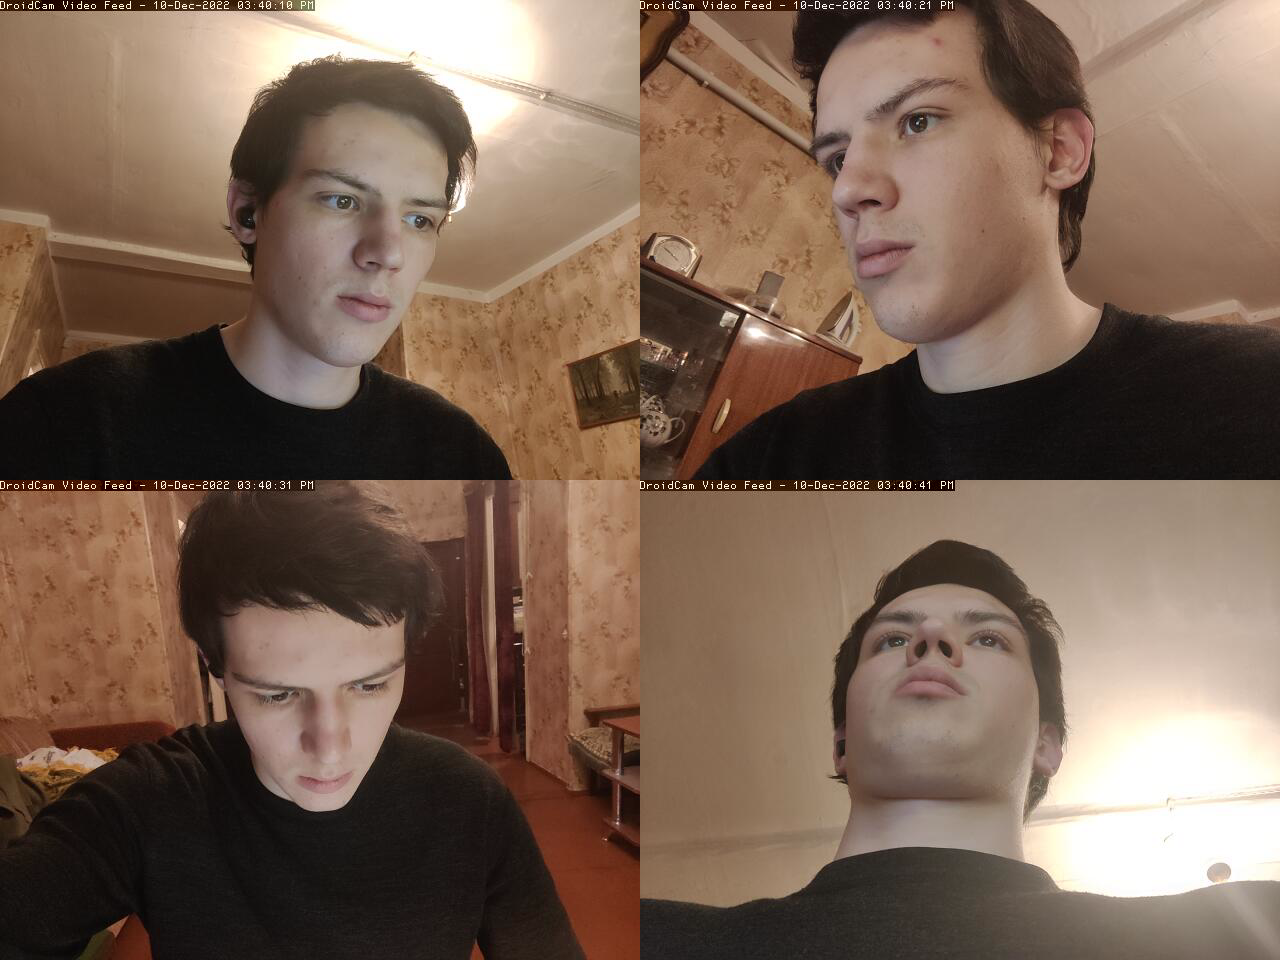

In [13]:
from PIL import Image
i1 = np.concatenate([frame1[:,:,::-1], frame2[:,:,::-1]], axis=1)
i2 = np.concatenate([frame3[:,:,::-1], frame4[:,:,::-1]], axis=1)

image = np.concatenate([i1,i2], axis=0)
Image.fromarray(image)

In [30]:
faces, locations, embeddings = detect_embedd(image, 'opencv', 'ArcFace')

In [31]:
tfaces, tloc, temb = detect_embedd(faces[0], 'opencv', 'ArcFace')

In [36]:
faces[0].shape

(301, 301, 3)

In [24]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
dists = pairwise_distances(embeddings, metric='cosine')
dists = cosine_similarity(embeddings)

In [28]:
dists

array([[0.99999994, 0.5586395 , 0.25916615, 0.44798428],
       [0.5586395 , 1.0000002 , 0.24480161, 0.5369859 ],
       [0.25916615, 0.24480161, 0.9999999 , 0.21765417],
       [0.44798428, 0.5369859 , 0.21765417, 1.0000001 ]], dtype=float32)

3.3031375


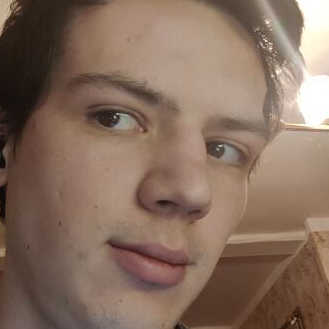

3.2909775


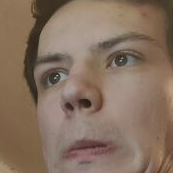

3.7262895


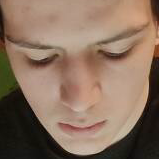

4.4766994


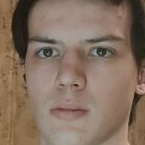

In [78]:
for f, e in zip(faces, embeddings):
    print(np.linalg.norm(e))
    Image.fromarray(f).show()